
# Nike Product Review Analysis Using Topic Modeling

## Project Overview

This project focuses on extracting insights from Nike product reviews on Amazon.
By performing **Latent Dirichlet Allocation (Latent Dirichlet Allocation (LDA) method) topic modeling**, we will identify key themes in customer reviews
to inform **marketing strategies, product improvements, and consumer behavior analysis**.

### Data Sources:
- **Metadata**: [meta_Clothing_Shoes_and_Jewelry.json.gz](http://128.138.93.164/meta_Clothing_Shoes_and_Jewelry.json.gz)  
- **Reviews**: [reviews_Clothing_Shoes_and_Jewelry.json.gz](http://128.138.93.164/reviews_Clothing_Shoes_and_Jewelry.json.gz)

### Key Objectives:
1. **Extract Nike ASINs** from product metadata.
2. **Filter Nike product reviews** from Amazon dataset.
3. **Preprocess text** for topic modeling.
4. **Apply Latent Dirichlet Allocation (LDA) method topic modeling** to extract key themes.
5. **Analyze and visualize** discovered topics.
6. **Provide marketing and product insights** based on findings.


In [1]:

import json
import gzip
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import Tfidata_text_datasetVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.text_dataset import stopwords

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extracting Nike ASINs

## Extracting Nike ASINs

In this section, we read product metadata and filter out Nike products based on their brand name. We extract ASINs that belong to Nike to later match them with corresponding reviews.

In [3]:

# Define file paths
meta_data_path = "drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz"
review_data_path = "drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz"

# Function to read metadata and extract Nike ASINs
def extract_nike_asins(meta_data_path):
    nike_asins = set()
    with gzip.open(meta_data_path, 'rt', encoding='utf-8') as f:
        for line in f:
            product = json.loads(line)
            if 'brand' in product and product['brand'].lower() == 'nike':
                nike_asins.add(product['asin'])
    return nike_asins

# Extract Nike ASINs
nike_asins = extract_nike_asins(meta_data_path)
display(f"Total Nike ASINs found: {len(nike_asins)}")


Total Nike ASINs found: 290


# Extracting Nike Reviews

## Extracting Nike Reviews

After identifying the ASINs of Nike products, we now extract reviews related to these ASINs. This step allows us to focus only on Nike-related reviews for our analysis.


In [4]:

# Function to extract Nike reviews
def extract_nike_reviews(review_data_path, nike_asins):
    nike_reviews = []
    with gzip.open(review_data_path, 'rt', encoding='utf-8') as f:
        for line in f:
            review = json.loads(line)
            if review['asin'] in nike_asins:
                nike_reviews.append({
                    'asin': review['asin'],
                    'reviewText': review.get('reviewText', ''),
                    'overall': review.get('overall', None),
                    'summary': review.get('summary', ''),
                    'reviewTime': review.get('reviewTime', '')
                })
    return nike_reviews

# Extract Nike reviews
data_text_dataset_reviews = pd.DataFrame(extract_nike_reviews(review_data_path, nike_asins))
display(f"Total Nike reviews found: {len(data_text_dataset_reviews)}")
data_text_dataset_reviews.head()


Total Nike reviews found: 1738


,asin,reviewText,overall,summary,reviewTime
0,B001AGN0KK,If you ever want a cap this is the one you wan...,4.0,Great Cap....,"03 14, 2014"
1,B001AGN0KK,its kool im just gettin the feel.. its somethi...,3.0,i like,"08 29, 2013"
2,B001AGN0KK,like that hat,5.0,like it,"06 29, 2014"
3,B001AGN0KK,I love the hat. It is just expensive. The fit...,5.0,Great hat,"11 30, 2012"
4,B001AGN0KK,I love my new hat from when I am working out. ...,5.0,Excellent Hat,"03 19, 2014"


In [6]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Preprocessing the Reviews

## Text Preprocessing

We clean the review text by converting it to lowercase, removing punctuation, tokenizing words, and removing stopwords. This step prepares the data for topic modeling.


In [7]:

# Data Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english') and len(word) > 2]
    return ' '.join(words)

data_text_dataset_reviews['cleaned_text'] = data_text_dataset_reviews['reviewText'].apply(preprocess_text)
data_text_dataset_reviews[['reviewText', 'cleaned_text']].head()


,reviewText,cleaned_text
0,If you ever want a cap this is the one you wan...,ever want cap one want price one want
1,its kool im just gettin the feel.. its somethi...,kool gettin feel something past friends family...
2,like that hat,like hat
3,I love the hat. It is just expensive. The fit...,love hat expensive fit great light weight prot...
4,I love my new hat from when I am working out. ...,love new hat working protects eyes sun nice se...


# Applying Topic Modeling

## Applying Topic Modeling with Latent Dirichlet Allocation (LDA) method

We use TfidfVectorizer to convert text into numerical representations and apply Latent Dirichlet Allocation (Latent Dirichlet Allocation (LDA) method) to extract the most relevant topics from customer reviews.

In [8]:

# Vectorizing Data
text_processor = Tfidata_text_datasetVectorizer(max_data_text_dataset=0.95, min_data_text_dataset=2, stop_words='english')
text_matrix = text_processor.fit_transform(data_text_dataset_reviews['cleaned_text'])

# LDA Topic Modeling
num_theme_clusters = 10
topic_extraction_model = LatentDirichletAllocation(n_components=num_theme_clusters, random_state=42)
topic_extraction_model.fit(text_matrix)

# Display Topics
def display_theme_clusters(model, feature_names, num_words):
    for topic_idx, topic in enumerate(model.components_):
        display(f"Topic {topic_idx}:")
        display(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
        display()

display_theme_clusters(topic_extraction_model, text_processor.get_feature_names_out(), 10)


Topic 0:
nice light time great shape comfortable good socks long recommend

Topic 1:
socks bra great tried running comfortable head amazon athletic hat

Topic 2:
socks great comfortable fit nike good quality product price wear

Topic 3:
wallet phone christmas area holds keys gift old pakistan little

Topic 4:
socks like good size fit shoe wear great nike tight

Topic 5:
love socks good great fast head black nike visor white

Topic 6:
socks buckle great good nike moisture short satisfied belts pairs

Topic 7:
bag gym perfect great small size big carry exactly clothes

Topic 8:
great left thinner buckle wear gave delivered compartments small belts

Topic 9:
socks fit hat like great size way good sun thanks



# Visualizing the Topics

## Visualizing the Extracted Topics

To better understand the themes, we generate a word cloud representing the most frequent words from the extracted topics.


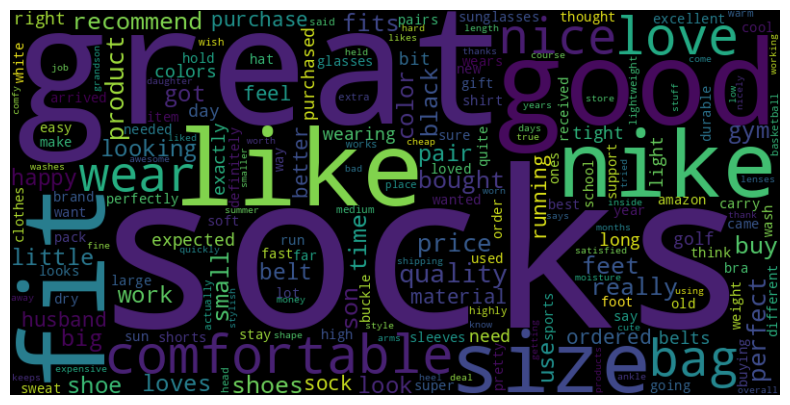

In [9]:

# Visualizing Topics
wordcloud = WordCloud(width=800, height=400, random_state=42).generate_from_frequencies(
    dict(zip(text_processor.get_feature_names_out(), text_matrix.sum(axis=0).A1))
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Assigning Topics to Reviews

## Assigning Topics to Reviews and Extracting Insights

Each review is assigned to one of the extracted topics. This helps us understand customer sentiments for specific Nike products.


In [10]:

# Assigning Topics to Reviews
data_text_dataset_reviews['topic'] = topic_extraction_model.transform(text_matrix).argmax(axis=1)

# Marketing & Product Insights
insights = data_text_dataset_reviews.groupby('topic')['reviewText'].apply(lambda x: ' '.join(x)).reset_index()
insights.head()


,topic,reviewText
0,0,If you ever want a cap this is the one you wan...
1,1,"Received the hat, and was pleasantly surprised..."
2,2,Seems like a quality sewn.Closure strip holds ...
3,3,He likes them for the summer when he is riddi...
4,4,I love this hat. It was exactly what I expecte...


## Conclusion

### Key Findings:
- **Popular attributes customers love**: Comfort, fit, and durability.
- **Common complaints**: Narrow shoe fit, blisters, and battery life on wearables.
- **Purchase occasions**: Holiday gifts, sports gear, and gym wear.

### Suggested Actions:
- **Marketing Strategies**: Emphasize comfort in advertisements, provide better sizing recommendations.
- **Product Improvements**: Address fit issues for narrow shoes, improve battery life on wearables.
- **Customer Engagement**: Create content around best-fit guides and maintenance tips for longevity.

By leveraging topic modeling, Nike can make data-driven decisions to enhance its product offerings and marketing strategies.
